**2020/21**

# Linear Regression
This lecture is about data prediction using linear regression and Spark MLlib.

As mentioned in previous lectures, Apache Spark provides a library for machine learning, with scalability and easy-to-use of uttmost importance. Actually there are two, one is RDD-based and another one is DataFrame-based. We will use MLlib, the DataFrame-based.

Hence, in this notebook we start by describing MLlib and then focus on prediction of data. 

The data to be used relates to AirBnB listings in Lisbon during a few months of 2017 (http://tomslee.net/airbnb-data-collection-get-the-data). It is expected that a proper task of data cleasing and preparation should be carried out.

# Spark MLlib

MLlib is a scalable machine learning library that provides a uniform set of high-level APIs that help users create and tune practical machine learning pipelines.


The MLlib package contain tools such as:
- ML algorithms: common algorithms for clustering, regression, classification, collaborative filtering, etc.
- Featurisation: feature extraction, transformation, dimensionality reduction, selection, etc.
- Pipelines: tools for constructing, evaluating and tuning ML pipelines.
- Persistence: to save and load algoirithms, models and pipelines.
- Utilities: linear algebra, statistics, data handling, etc.

In other words, it provides a uniform set of high-level APIs that help users to create and tune practical ML pipelines. 

In general, a typical ML workflow is designed to work as depicted below:

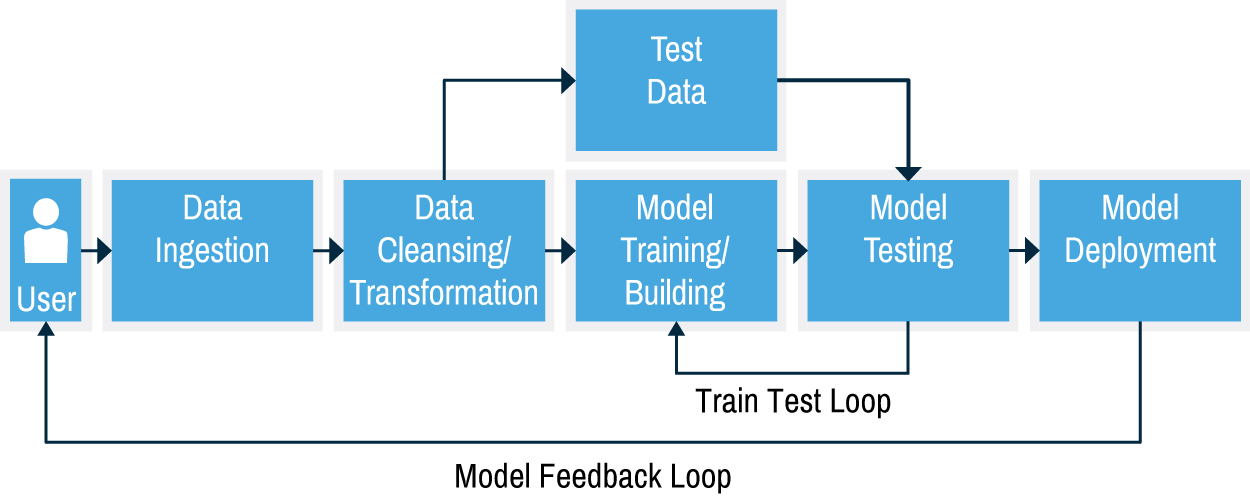


You will find additional details about Spark MLlib in http://spark.apache.org/docs/latest/ml-guide.html

In [ ]:
# Some imports 

import os 

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Exercise

This exercise is about **Price Prediction** in the leisure industry, namely Airbnb rental prices in Lisbon, considering a particular timeframe.

The functional requirements for the Spark program you are about to create are as follows:

1. Read the dataset and carry out tasks of data cleasing and preparation, so ending up with a preprocessed dataset. In particular:
    * select an appropriate subset of columns of interest for ML analysis;
    * remove outliers, e.g. nulls and extreme values;
    * convert all integer fields to doubles;
    * fill in missing numerical values whenever appropriate.
    
    All this should include an understanding of the data, kind of data exploration, both textual/numerical and visual. 
2. Build a simple linear regression model focussing on just predicting the `price` given the number of `bedrooms`. 
3. Apply the model to data not yet used by the model and evaluate the predictions.

## Data schema


**Column description**


|Column     | Description |
|:---:|:---:|
| **room_id** | A unique number identifying an Airbnb listing. The listing has a URL on the Airbnb web site of http://airbnb.com/rooms/room_id |
| **host_id** | A unique number identifying an Airbnb host. The host’s page has a URL on the Airbnb web site of http://airbnb.com/users/show/host_id |
| **room_type** | One of “Entire home/apt”, “Private room”, or “Shared room” |
| **borough** | A subregion of the city or search area for which the survey is carried out. |
| **neighborhood**  |Likewise borough: a subregion of the city or search area for which the survey is carried out. For cities that have both, a neighbourhood is smaller than a borough. For some cities there is no neighborhood information. |
| **reviews** | The number of reviews that a listing has received. Airbnb has said that 70% of visits end up with a review, so the number of reviews can be used to estimate the number of visits. Note that such an estimate will not be reliable for an individual listing (especially as reviews occasionally vanish from the site), but over a city as a whole it should be a useful metric of traffic. |
| **overall_satisfaction** | The average rating (out of five) that the listing has received from those visitors who left a review. |
| **accommodates**  | The number of guests a listing can accommodate. |
| **bedrooms** |  The number of bedrooms a listing offers. |
| **price** |  The price (in US dollars) for a night stay. In early surveys, there may be some values that were recorded by month. |
| **minstay** |  The minimum stay for a visit, as posted by the host. |
| **name** |  A description/marketing message about the listing. |
| **latitude** |  The latitude of the listing as posted on the Airbnb site. |
| **longitude** |  The longitude of the listing as posted on the Airbnb site: this may be off by a few hundred metres. |
    
*Notice*: location as indicated by latitude and longitude may be off by a few metres.

## Useful visualization functions

Some functions that we can use to plot data but as Python dataframes

**Disclaimer**: these functions are broadly distributed among users. Further adjustments are needed and/or advisable.

In [ ]:
# Distribution graphs (histogram/bar graph) of column data

# TODO: Further adjustments are needed and/or advisable
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# correlation matrix

# TODO: Further adjustments are needed and/or advisable
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()


In [ ]:
# scatter and density plots

# TODO: Further adjustments are needed and/or advisable
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


## Data ingestion

In [ ]:
! pwd 
! ls -la
! head -n 1 airbnb_lisbon_2017Q2toQ3.csv
! tail -n 1 airbnb_lisbon_2017Q2toQ3.csv

In [ ]:
# some Spark related imports

import sys

# from pyspark.sql import SparkSession
# from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *


In [ ]:
# read the dataset 
# this time we will be using pyspark.sql.DataFrameReader.csv
filepath = "airbnb_lisbon_2017Q2toQ3.csv"

dfraw = 

In [ ]:
# build a SparkSession instance if one does not exist. Notice that we can only have one per JVM
# spark = SparkSession\
#          .builder\
#          .appName("JaneStreet")
#          .getOrCreate()

## Exploratory data analysis

Let us get some insight from data

In [ ]:
# check the data - schema, columns and count


### Data of interest
We may just want to deal with certain columns of the data

In [ ]:
# check the columns, one by one


In [ ]:
# it looks like we will drop the following columns as we do not need them, 
# not to mentioning the nulls

cols_to_drop = ["country", "borough", "bathrooms", "minstay", "name",
                             "last_modified", "location;;"]

cols_interest = [x for x in rawcols if x not in cols_to_drop] 
cols_interest

In [ ]:
dfraw_interest = 

### Data cleasing
Once data of interest is established, the goal now is to get a clean dataset so we can proceed with our analysis. In particular, we will look at
* Nulls
* Data types
* Extreme values

#### Nulls
We can handle null values in different ways. 
For example:
* Drop any records that contain nulls
* Numeric:
  * Replace them with mean/median/zero/etc.
* Categorical:
  * Replace them with the mode
  * Create a special category for null

Notice that sometimes there are nulls for some reason. For example, it may signify that a column needs to be computed in a particular mode, or predicted. But if there is any setting, it is worth considering to add and additional field stating the case.

In [ ]:
# remove rows where any of the columns is null

dfraw_interest_clean1 = 

#### Data types
We should check if the column data types are OK. To do so, first we have to look at the schema above. Change any data type if advisable, by applying `cast` with the wanted type to the column at stake. For example: 

*... .withColumn("ColA", col("ColA").cast(DoubleType()))*

But probably there are reasons why the DataFrame shows such incongruences. It is advisable to remove the origin of the problems. We leave this issue for further discussion, including the use of `Imputer` from Spark ML, an imputation estimator for completing missing values.


In [ ]:
# check the colums again, just the ones of interest, one by one



In [ ]:
# needs to be changed:
# accommodates: string to numeric (double - because algorithms want float/doubles) 
# latitude: string to numeric (double)
# others !!!

dfraw_interest_clean2 = dfraw_interest_clean1 \
    .withColumn("accommodates", dfraw_interest_clean1['accommodates'].cast(DoubleType())) \
    .withColumn("latitude", dfraw_interest_clean1['latitude'].cast(DoubleType()))

dfraw_interest_clean2.printSchema()

#### Outliers
We should get rid of some outliers that exist in the data, by setting some value boundaries in respect to certain columns 

In [ ]:
# Let us take a look as it stands now. For that, we use summary(), one column by one



In [ ]:
# There are some minimum values to uphold. To name some columns:
# bedrooms
# accommodates
#
# filter in a way that such columns will have values bigger than 0

dfclean = 


[dfraw_interest_clean2.count(), dfclean.count()]

In [ ]:
# Further cleaning procedures can be applied 
# We leave such decisions for you



#### Saving the clean dataset

In [ ]:
# save the clean DataFrame to a file for future use, just in case

# this time we are going to use the parquet format, so commom in Spark 
cleanfilename = "clean-airbnb-lisbon2017"
dfclean.write.mode("overwrite").parquet(cleanfilename)

# check in your running directory if that was accomplished

# and later on, we can use spark.read.parquet() to load the file

#### Final  overview
After establishing the clean data, let us get an overview about what we have achieved, with some statistics and visualizations.

In [ ]:
# use of Correlation from pyspark.ml.stat
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# check some columns e.g. resp vs weight; 
# Correlation needs vectors so we convert to vector column first

numeric_cols = ["accommodates", "bedrooms", "price"]
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(dfclean).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).head()
print("Pearson correlation matrix:\n" + str(matrix[0]))

In [ ]:
# convert to Pandas the DataFrame with the numeric columns set above, 
# just for visualization purposes
df_plot =

In [ ]:
# scatter and density plot, a function defined at the beginning of the notebook
plotScatterMatrix(df_plot, 20, 12)

#### Clear some objects from memory
If some objects are no further needed, we may delete them now

In [ ]:
del .., ..., 

## Prediction model
Given the clean dataset we obtained, we can now start to train and test a model which can be used then to predict new data instances. The steps are as follows:

1. Split the dataset into two groups: `train` and `test`
2. Build a simple linear regression model focussing on just predicting the `price` given the number of `bedrooms`. 
3. Apply the model to `test` group and figure out how it performs.

**Notice: caching parts of data**

It is a good idea to have parts of the dataset that is going to be heavily used by ML algorithms in cache so it makes accesses faster (but we should not have many in cache!)

### Train/Test split


The step of creating a ML model means we should keep some part of our data in the dark.
Standard split is 80/20. 

Notice that if the test part is too low, then the model will memorize the data so it will reach an overfit situation.
That would be bad as it no longer have data to evaluate how well it will generalize to unseen data.

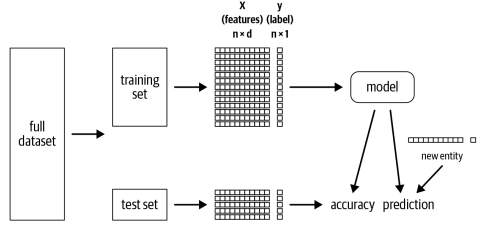   

In [ ]:
# train/test split
#
# Some aspects to consider:
# 1. we must set a seed due to reproducibility issues 
#    so to achieve consistent results. And what about 42? 
# 2. different configuration of cluster affects the split. If we really want 
#    to guarantee reproducibility, we have to store the outcome once and then 
#    use it as needed.

dftrain, dftest = 

# caching data ... but just the train
dftrain.cache()

# print the number of rows in each part


### Feature transformation

Similarly to other ML algorithms, linear regression requires that all input features are contained within a single vector. Therefore we need a transformation.

To do so we will use the `VectorAsAssembler` transformer.

Transformers accept a DataFrame as input and return a new one with one or more columns appended to it, using a `transform()` method following rule-based transformations - they do not learn from the data. Notice that they are lazilly evaluated.

In [ ]:
# recall the two columns under analysis, price and bedrooms, and show a summary
dftrain.select("price", "bedrooms").summary().show()

# keep in mind those numbers, in particular the min, max values

In [ ]:
# get the vector assembler and subsequent train

from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
vec_dftrain = vec_assembler.transform(dftrain)

# show the content of the columns bedrooms, features and price
vec_dftrain.select

### Linear Regression
Once we have the vector assembler in place, then we can use the `LinearRegression` estimator to build the model. As an estimator, it accepts a DataFrame as input and returns a model. This DataFrame input is going to be the output of the transformer.

The estimators learn parameters from the data, have a `.fit()` method and are immediately evaluated.

In [ ]:
from pyspark.ml.regression import LinearRegression

# returns a transformer that is the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(vec_dftrain)

### Model inspection
Having learned the parameters, the transformer can applied them to new data points in order to generate predictions. Let us check such parameters, `coefficients` and `intercept`.

In [ ]:
m =  
b =  

# print the linear regression line

print(f"The formula for the linear regression line is: \tprice = {m[0]}*bedrooms + {b}")

### Pipeline
It is time to apply the model built to the test set. But, again, we have to prepare the data like we did for training, with the help of a vector assembler.

Fortunately, there are `pipelines` available, which are useful in a sense that we specify the stages we want the data to pass and the rest is up to Spark. And pipelines are estimators.

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vec_assembler, lr_model])

# get the model (as transformer)
pipeline_model = pipeline.fit(dftrain)

### Applying to the test set
Since the pipeline model is a transformer, we can easily apply it to the testing data.

In [ ]:
df_prediction = pipeline_model.transform(dftest)

# show the columns worth to be looked at

df_prediction.select

### Visual analysis
Plotting the `price` versus `prediction` obtained above.

In [ ]:
# we leave it now ...

# Additional exercise

Once the previous exercise has been completed, create a new notebook with similar implementation but taken into consideration the following:
1. Apply extra rules in order to obtain a better clean dataset.
2. Adapt the linear regression model but considering a different column for the single feature.

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/